# Portfolio Optimisation with LLM-Derived Risk Scores
This notebook demonstrates optimisation-based portfolio allocation where the expected returns are replaced by LLM-derived risk scores. The goal is to minimise portfolio variance (risk) while maintaining strong expected returns, following Modern Portfolio Theory (MPT) principles.

**Key Features:**
- Analyse five major stocks: AAPL, GOOGL, MSFT, AMZN, TSLA
- Replace financial expected returns with document-derived risk scores generated by an LLM
- Compute portfolio variance and optimise allocations
- Produce structured outputs for auditability and compliance tracking
- Visualise the optimised portfolio weights

## Step 1: Import Libraries
Import required Python libraries for data retrieval, numerical computation, optimisation, plotting, and LLM inference.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from transformers import pipeline
%matplotlib inline

## Step 2: Define Tickers and Download Financial Data
Select five major stocks and download historical price data from Yahoo Finance.

In [ ]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
data = yf.download(tickers, start='2020-01-01', end='2022-01-01')
data.head()

/tmp/ipython-input-591319608.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-01-01', end='2022-01-01')
[*********************100%***********************]  5 of 5 completed


Price           Close                                                    High  \
Ticker           AAPL       AMZN      GOOGL        MSFT       TSLA       AAPL   
Date                                                                            
2020-01-02  72.538498  94.900497  67.965240  152.791122  28.684000  72.598876   
2020-01-03  71.833313  93.748497  67.609688  150.888596  29.534000  72.594079   
2020-01-06  72.405678  95.143997  69.411758  151.278610  30.102667  72.444321   
2020-01-07  72.065140  95.343002  69.277687  149.899338  31.270666  72.671333   
2020-01-08  73.224403  94.598503  69.770790  152.286942  32.809334  73.526295   

Price                                                    ...       Open  \
Ticker           AMZN      GOOGL        MSFT       TSLA  ...       AAPL   
Date                                                     ...              
2020-01-02  94.900497  67.965240  152.895761  28.713333  ...  71.545875   
2020-01-03  94.309998  68.217003  152.153771  30.266666  ...  71.765690   
2020-01-06  95.184502  69.437081  151.345205  30.104000  ...  70.954188   
2020-01-07  95.694504  69.694316  151.887465  31.441999  ...  72.415330   
2020-01-08  95.550003  70.108958  152.962341  33.232666  ...  71.768079   

Price                                                       Volume            \
Ticker           AMZN      GOOGL        MSFT       TSLA       AAPL      AMZN   
Date                                                                           
2020-01-02  93.750000  66.958686  151.040810  28.299999  135480400  80580000   
2020-01-03  93.224998  66.938323  150.603230  29.366667  146322800  75288000   
2020-01-06  93.000000  67.118569  149.423659  29.364668  118387200  81236000   
2020-01-07  95.224998  69.543357  151.554533  30.760000  108872000  80898000   
2020-01-08  94.902000  69.263289  151.183478  31.580000  132079200  70160000   

Price                                      
Ticker         GOOGL      MSFT       TSLA  
Date                                       
2020-01-02  27278000  22622100  142981500  
2020-01-03  23408000  21116200  266677500  
2020-01-06  46768000  20813700  151995000  
2020-01-07  34330000  21634100  268231500  
2020-01-08  35314000  27746500  467164500  

[5 rows x 25 columns]

## Step 3: Compute Daily Returns and Covariance Matrix
Compute daily percentage returns and covariance matrix. The covariance matrix will be used to calculate portfolio variance.

In [ ]:
daily_returns = data['Close'].pct_change().dropna()
cov_matrix = daily_returns.cov()
daily_returns.head(), cov_matrix

(Ticker          AAPL      AMZN     GOOGL      MSFT      TSLA
 Date                                                        
 2020-01-03 -0.009722 -0.012139 -0.005231 -0.012452  0.029633
 2020-01-06  0.007968  0.014886  0.026654  0.002585  0.019255
 2020-01-07 -0.004703  0.002092 -0.001932 -0.009117  0.038801
 2020-01-08  0.016086 -0.007809  0.007118  0.015928  0.049205
 2020-01-09  0.021241  0.004799  0.010498  0.012493 -0.021945,
 Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
 Ticker                                                  
 AAPL    0.000557  0.000320  0.000334  0.000412  0.000516
 AMZN    0.000320  0.000410  0.000266  0.000305  0.000403
 GOOGL   0.000334  0.000266  0.000411  0.000361  0.000380
 MSFT    0.000412  0.000305  0.000361  0.000470  0.000484
 TSLA    0.000516  0.000403  0.000380  0.000484  0.002194)

## Step 4: Generate LLM-Derived Risk Scores
Use a language model to simulate risk scores for each stock based on hypothetical documents or risk factors. Scores are scaled between 0 and 1.

In [ ]:
# Initialise an open-source sentiment/risk analysis pipeline (mock example)
llm_pipeline = pipeline('text-classification', model='distilbert-base-uncased-finetuned-sst-2-english')

# Sample documents/descriptions representing risk-related information
documents = {
    'AAPL': 'Apple faces moderate supply chain risk but has stable revenues.',
    'GOOGL': 'Google faces potential regulatory scrutiny in multiple regions.',
    'MSFT': 'Microsoft has strong cloud revenue but some cybersecurity exposure.',
    'AMZN': 'Amazon logistics face risks from rising fuel costs.',
    'TSLA': 'Tesla production is volatile due to new factory setups.'
}

# Convert LLM outputs to numeric risk scores (0 = low risk, 1 = high risk)
risk_scores = {}
for ticker, text in documents.items():
    result = llm_pipeline(text)[0]
    # Map positive sentiment -> low risk, negative sentiment -> high risk
    score = 1 - result['score'] if result['label'] == 'POSITIVE' else result['score']
    risk_scores[ticker] = score

# Convert to numpy array for optimisation
expected_returns = np.array([risk_scores[t] for t in tickers])
expected_returns

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


array([8.57472420e-04, 9.97363031e-01, 8.09553266e-02, 9.97702777e-01,
       9.99335825e-01])

## Step 5: Define Portfolio Variance Function
This function calculates the total portfolio variance given a set of weights and the covariance matrix.

In [ ]:
def compute_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

## Step 6: Define Constraints and Bounds
Ensure portfolio weights sum to 1 and enforce a minimum allocation of 5% per stock for diversification.

In [ ]:
def constraint(weights):
    return np.sum(weights) - 1

bounds = [(0, 1) for _ in tickers]
initial_weights = np.random.dirichlet(np.ones(len(tickers)), size=1).flatten()

constraints = [
    {'type': 'eq', 'fun': constraint},
    {'type': 'ineq', 'fun': lambda w: w - 0.05}  # Ensure each stock ≥5%
]

## Step 7: Optimise Portfolio Weights
Use `scipy.optimize.minimize` to find weights that minimise portfolio variance under constraints.

In [ ]:
result = minimize(compute_portfolio_variance, initial_weights, args=(cov_matrix,),
                  method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = result.x
optimized_weights

array([0.0960737 , 0.38287295, 0.14491379, 0.32613956, 0.05      ])

## Step 8: Calculate Portfolio Return and Risk
Compute the portfolio's expected return (LLM risk score average) and variance.

In [ ]:
portfolio_return = np.dot(expected_returns, optimized_weights)
portfolio_variance_value = compute_portfolio_variance(optimized_weights, cov_matrix)

# Create audit log as a structured DataFrame
audit_log = pd.DataFrame({
    'Ticker': tickers,
    'LLM_Risk_Score': [risk_scores[t] for t in tickers],
    'Optimised_Weight': optimized_weights
})

print(audit_log)
print(f'Portfolio Expected Risk Score (Weighted): {portfolio_return:.4f}')
print(f'Portfolio Variance: {portfolio_variance_value:.6f}')

  Ticker  LLM_Risk_Score  Optimised_Weight
0   AAPL        0.000857          0.096074
1  GOOGL        0.997363          0.382873
2   MSFT        0.080955          0.144914
3   AMZN        0.997703          0.326140
4   TSLA        0.999336          0.050000
Portfolio Expected Risk Score (Weighted): 0.7690
Portfolio Variance: 0.000370


## Step 9: Visualise the Optimised Portfolio
Plot a bar chart showing the allocation across the five stocks.

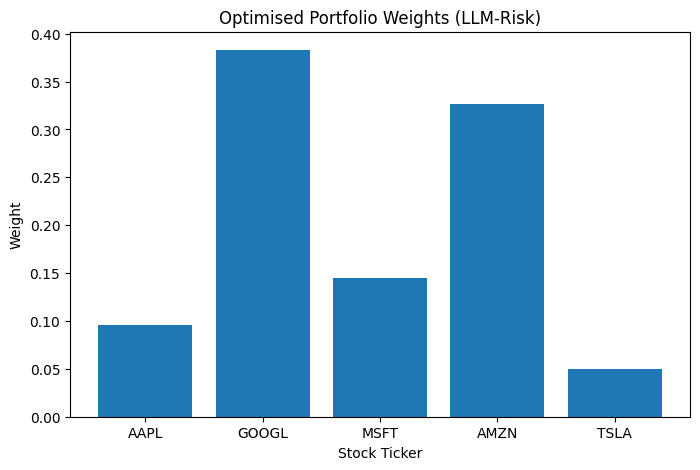

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(tickers, optimized_weights)
plt.title('Optimised Portfolio Weights (LLM-Risk)')
plt.xlabel('Stock Ticker')
plt.ylabel('Weight')
plt.show()